# MLP
MLP, K=5, epochs=200.
Use mRNA.
Train set: filter middle.
Valid set: filter none.

In [1]:
from datetime import datetime
print(datetime.now())

2023-04-01 23:40:15.712997


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=200 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = True
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = True
FILTER_TEST         = True
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = True

Python 3.9.16
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.pc_RCI.csv'
RCI_FILE_VALID = 'train.pc_RCI.csv'
RCI_FILE_TEST  = None # else 'test.pc_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_pc_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_pc_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_pc_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [7]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(64, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    layer3 = Dense(64, activation='sigmoid')
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(layer3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return mlp

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-01 23:40:47.776121
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                65664     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 74,049
Trainable params: 74,049
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
            self.discriminator = 0    # more balanced for mRNA
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            self.model.save(filename)
        
    def load_model(self,filename):
        self.model = keras.models.load_model(filename)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        # lncRNA
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        # mRNA
        filename='pc.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if not FILTER_TEST or \
                    (FILTER_TAILS_TEST and in_middle) or \
                    (FILTER_MIDDLE_TEST and in_tails):
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if not FILTER_TRAIN or \
                    (FILTER_TAILS_TRAIN and in_middle) or \
                    (FILTER_MIDDLE_TRAIN and in_tails):
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-01 23:40:48.755419
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.pc_RCI.csv
Number of RCI values loaded 13669
Num RCI: 13669
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_pc_transcripts.csv
Loaded 13669 sequences.
2023-04-01 23:42:15.238784

Training # 1 1
2023-04-01 23:42:15.240581
2023-04-01 23:42:15.240664
Discriminator ZERO 0
Train 1:0 5722:887 86.58%
Computed class weights: {0: 3.725479143179256, 1: 0.5775078643830829}
Valid 1:0 1417:217 86.72%
FIT
2023-04-01 23:42:15.373865


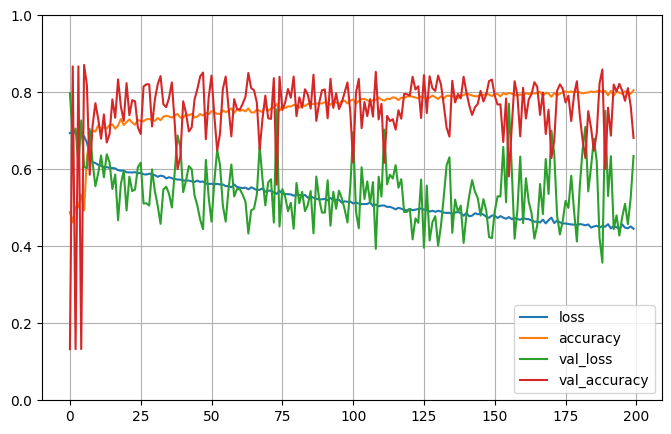


2023-04-01 23:45:39.007078

Testing # 1 1
2023-04-01 23:45:39.007225
2023-04-01 23:45:39.007282
PREDICT
2023-04-01 23:45:39.040576
Test 1:0 1417:217 86.72%
Predict 1:0 1006:628 61.57%
Test sizes (1634, 1025) (1634,)
Range of scores: 0.0036940514 to 0.9962913
Score threshold 0.5
Confusion matrix
 [[162  55]
 [466 951]]
Normalized matrix
 [[0.09914321 0.03365973]
 [0.28518972 0.58200734]]


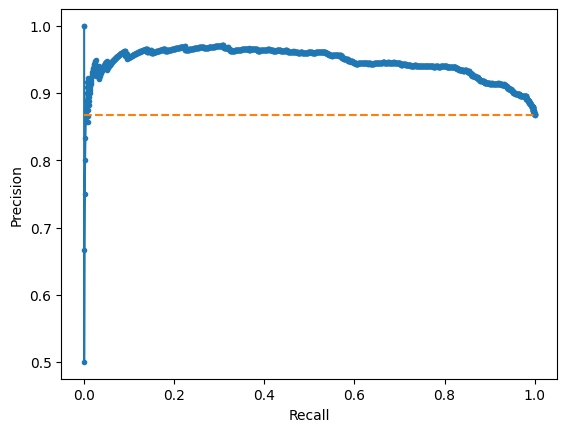

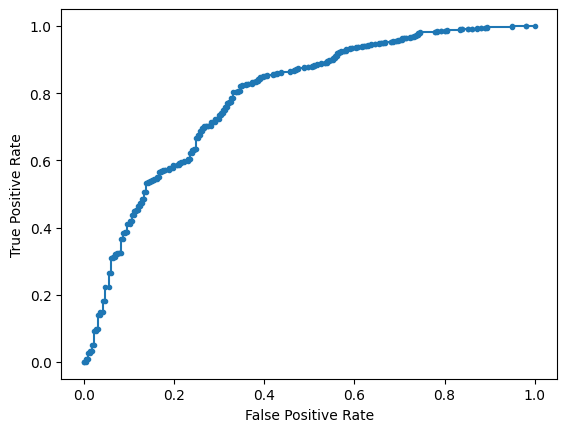

Accuracy: 68.12% Precision: 94.53% Recall: 67.11%
F1: 78.50% MCC: 0.2914
AUPRC: 94.63% AUROC: 78.67%
 accuracy [68.11505507955935]
 precision [94.53280318091451]
 recall [67.1136203246295]
 F1 [78.49773008666942]
 MCC [0.2913933533621168]
 AUPRC [94.62960890434692]
 AUROC [78.67078171902084]
2023-04-01 23:45:40.201261

Training # 1 2
2023-04-01 23:45:40.203456
2023-04-01 23:45:40.203554
Discriminator ZERO 0
Train 1:0 5688:887 86.51%
Computed class weights: {0: 3.706313416009019, 1: 0.5779711673699015}
Valid 1:0 1451:217 86.99%
FIT
2023-04-01 23:45:40.344125


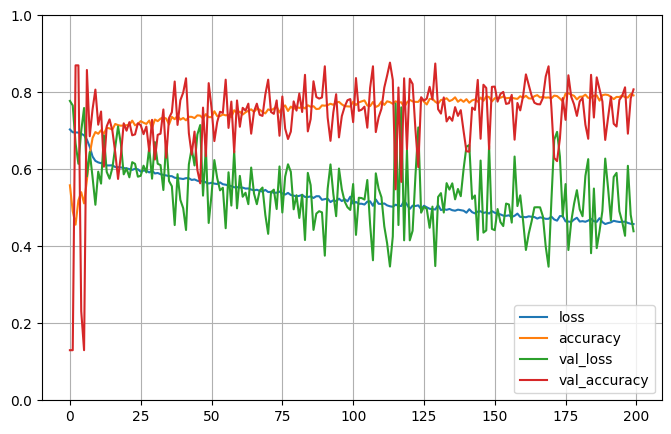


2023-04-01 23:49:04.045691

Testing # 1 2
2023-04-01 23:49:04.054558
2023-04-01 23:49:04.055091
PREDICT
2023-04-01 23:49:04.092764
Test 1:0 1451:217 86.99%
Predict 1:0 1296:372 77.70%
Test sizes (1668, 1025) (1668,)
Range of scores: 0.0016941114 to 0.9991155
Score threshold 0.5
Confusion matrix
 [[ 134   83]
 [ 238 1213]]
Normalized matrix
 [[0.08033573 0.04976019]
 [0.14268585 0.72721823]]


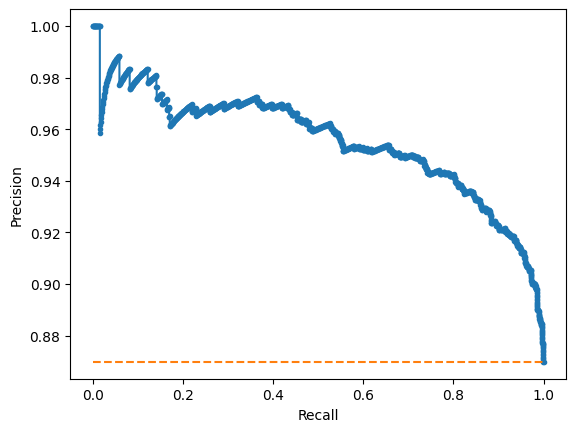

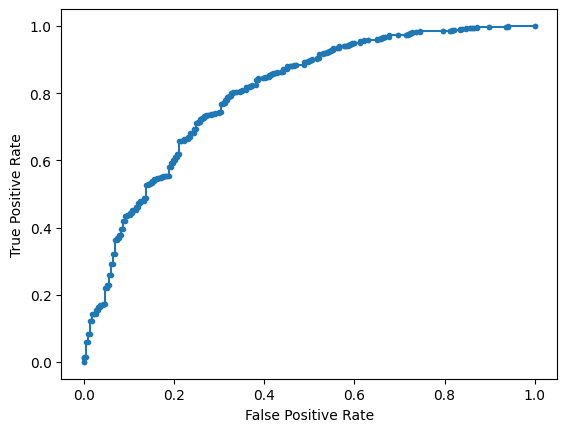

Accuracy: 80.76% Precision: 93.60% Recall: 83.60%
F1: 88.31% MCC: 0.3665
AUPRC: 95.53% AUROC: 79.90%
 accuracy [80.75539568345323]
 precision [93.59567901234568]
 recall [83.59751895244659]
 F1 [88.31452493629415]
 MCC [0.3664832808689075]
 AUPRC [95.5281542710768]
 AUROC [79.89595607034082]
2023-04-01 23:49:05.599493

Training # 1 3
2023-04-01 23:49:05.600804
2023-04-01 23:49:05.600873
Discriminator ZERO 0
Train 1:0 5711:887 86.56%
Computed class weights: {0: 3.719278466741826, 1: 0.5776571528628962}
Valid 1:0 1428:217 86.81%
FIT
2023-04-01 23:49:05.765454


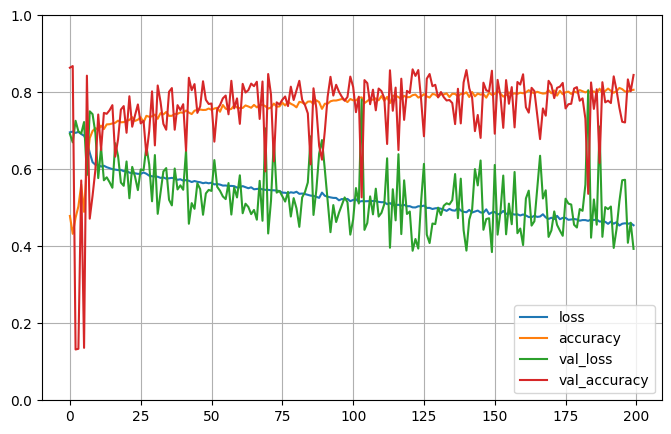


2023-04-01 23:51:59.480574

Testing # 1 3
2023-04-01 23:51:59.480714
2023-04-01 23:51:59.480767
PREDICT
2023-04-01 23:51:59.496498
Test 1:0 1428:217 86.81%
Predict 1:0 1403:242 85.29%
Test sizes (1645, 1025) (1645,)
Range of scores: 0.003834299 to 0.9864957
Score threshold 0.5
Confusion matrix
 [[ 102  115]
 [ 140 1288]]
Normalized matrix
 [[0.06200608 0.06990881]
 [0.08510638 0.78297872]]


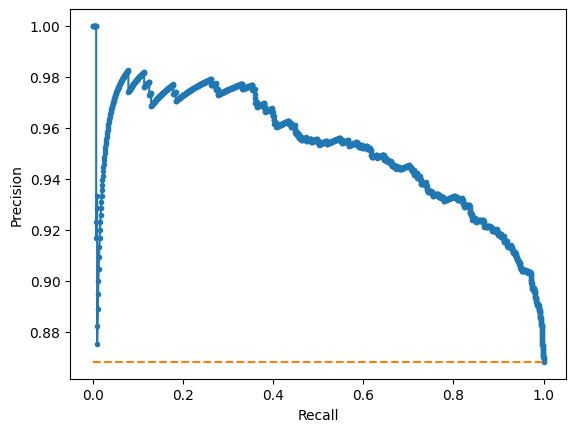

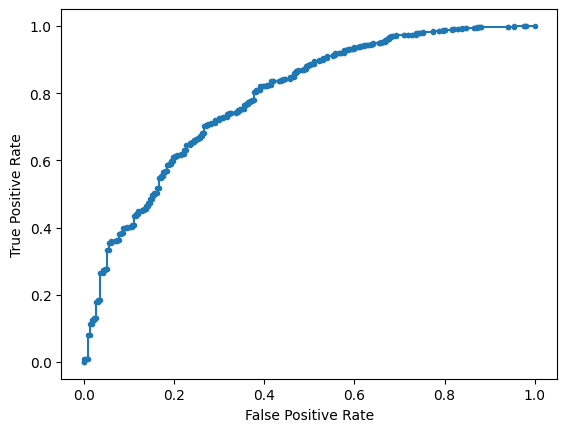

Accuracy: 84.50% Precision: 91.80% Recall: 90.20%
F1: 90.99% MCC: 0.3554
AUPRC: 95.16% AUROC: 78.67%
 accuracy [84.49848024316108]
 precision [91.80327868852459]
 recall [90.19607843137256]
 F1 [90.9925821264571]
 MCC [0.35539262334337846]
 AUPRC [95.15749003602143]
 AUROC [78.6685641998735]
2023-04-01 23:52:00.505987

Training # 1 4
2023-04-01 23:52:00.507881
2023-04-01 23:52:00.507955
Discriminator ZERO 0
Train 1:0 5701:878 86.65%
Computed class weights: {0: 3.746583143507973, 1: 0.5770040343799333}
Valid 1:0 1438:226 86.42%
FIT
2023-04-01 23:52:00.655481


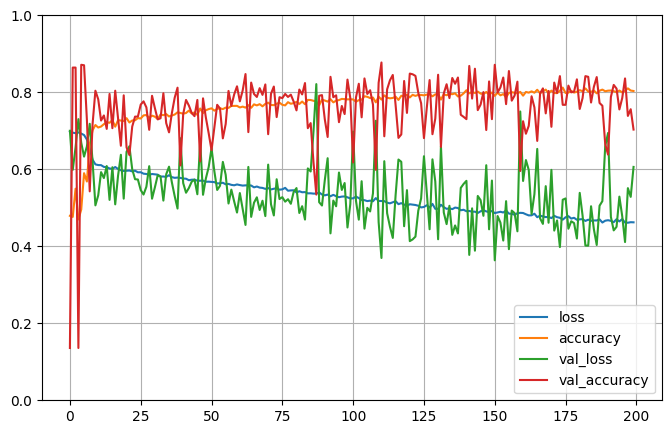


2023-04-01 23:54:49.126463

Testing # 1 4
2023-04-01 23:54:49.126552
2023-04-01 23:54:49.126601
PREDICT
2023-04-01 23:54:49.148000
Test 1:0 1438:226 86.42%
Predict 1:0 1046:618 62.86%
Test sizes (1664, 1025) (1664,)
Range of scores: 0.0055837 to 0.97663826
Score threshold 0.5
Confusion matrix
 [[175  51]
 [443 995]]
Normalized matrix
 [[0.10516827 0.03064904]
 [0.26622596 0.59795673]]


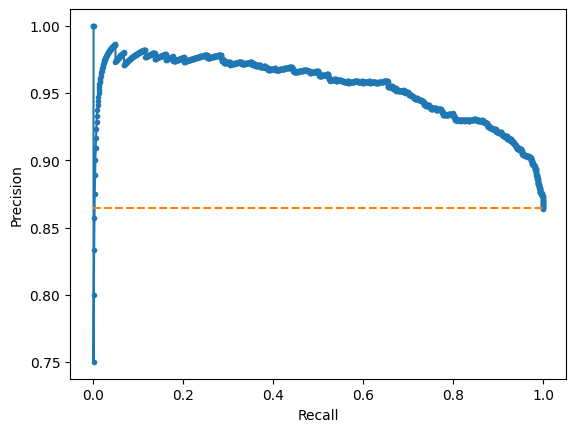

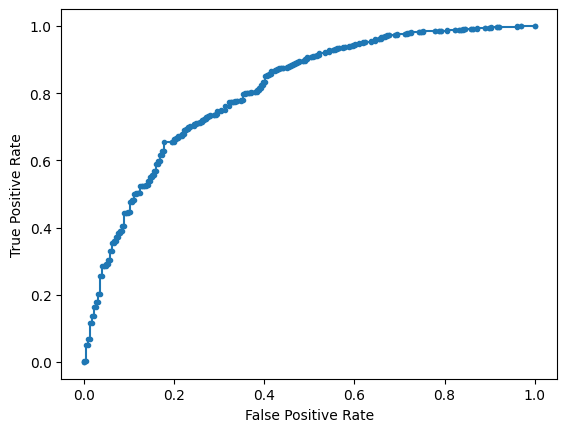

Accuracy: 70.31% Precision: 95.12% Recall: 69.19%
F1: 80.11% MCC: 0.3306
AUPRC: 95.49% AUROC: 80.63%
 accuracy [70.3125]
 precision [95.12428298279158]
 recall [69.19332406119611]
 F1 [80.11272141706924]
 MCC [0.33060591003262746]
 AUPRC [95.48598228580893]
 AUROC [80.62851551441898]
2023-04-01 23:54:50.184442

Training # 1 5
2023-04-01 23:54:50.189028
2023-04-01 23:54:50.189464
Discriminator ZERO 0
Train 1:0 5734:877 86.73%
Computed class weights: {0: 3.7690992018244014, 1: 0.5764736658528078}
Valid 1:0 1405:227 86.09%
FIT
2023-04-01 23:54:50.360330


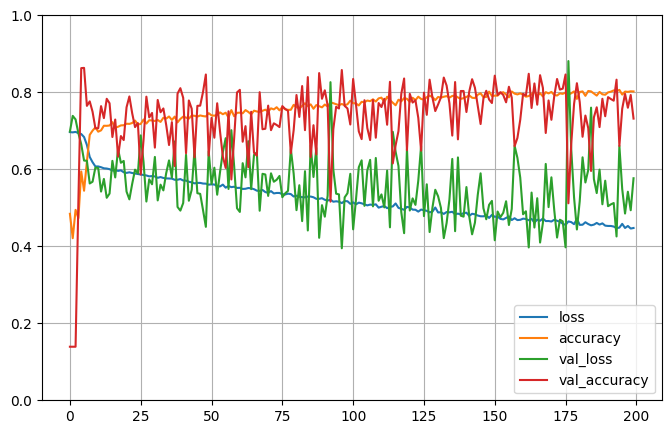


2023-04-01 23:57:35.946536

Testing # 1 5
2023-04-01 23:57:35.946942
2023-04-01 23:57:35.947001
PREDICT
2023-04-01 23:57:35.974233
Test 1:0 1405:227 86.09%
Predict 1:0 1111:521 68.08%
Test sizes (1632, 1025) (1632,)
Range of scores: 0.001621966 to 0.99756694
Score threshold 0.5
Confusion matrix
 [[ 155   72]
 [ 366 1039]]
Normalized matrix
 [[0.09497549 0.04411765]
 [0.22426471 0.63664216]]


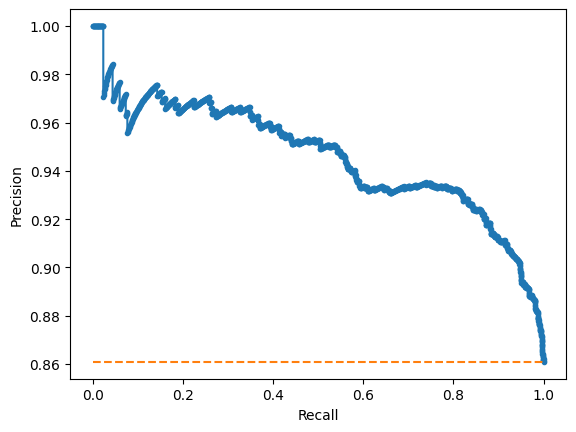

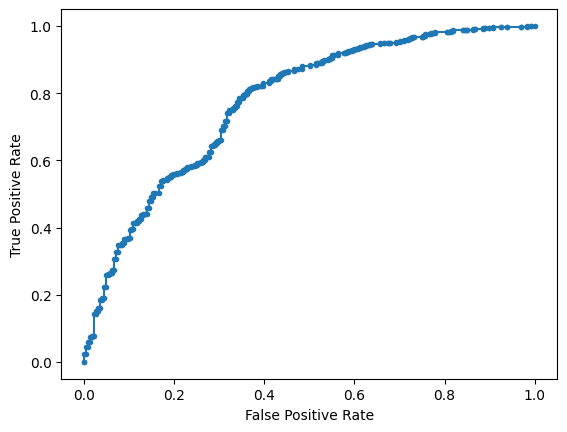

Accuracy: 73.16% Precision: 93.52% Recall: 73.95%
F1: 82.59% MCC: 0.3135
AUPRC: 94.59% AUROC: 77.38%
 accuracy [73.16176470588235]
 precision [93.51935193519351]
 recall [73.95017793594306]
 F1 [82.59141494435613]
 MCC [0.3134859233200089]
 AUPRC [94.5916532364224]
 AUROC [77.37814915264866]
2023-04-01 23:57:37.092415

Training # 2 1
2023-04-01 23:57:37.092662
2023-04-01 23:57:37.092726
Discriminator ZERO 0
Train 1:0 5710:883 86.61%
Computed class weights: {0: 3.733295583238958, 1: 0.5773204903677759}
Valid 1:0 1429:221 86.61%
FIT
2023-04-01 23:57:37.217637


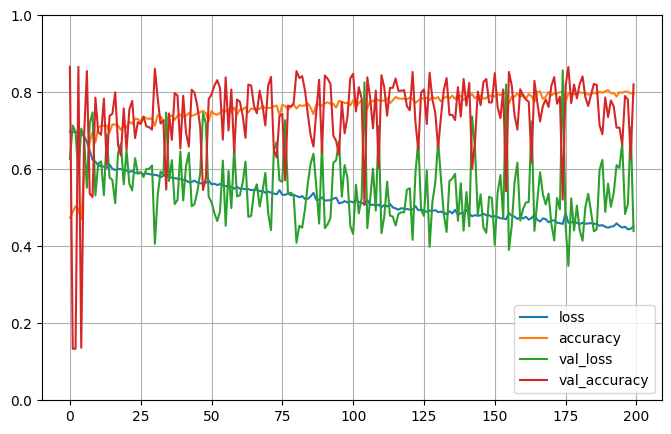


2023-04-02 00:00:28.042815

Testing # 2 1
2023-04-02 00:00:28.042946
2023-04-02 00:00:28.043008
PREDICT
2023-04-02 00:00:28.076059
Test 1:0 1429:221 86.61%
Predict 1:0 1335:315 80.91%
Test sizes (1650, 1025) (1650,)
Range of scores: 0.0025428121 to 0.99915564
Score threshold 0.5
Confusion matrix
 [[ 120  101]
 [ 195 1234]]
Normalized matrix
 [[0.07272727 0.06121212]
 [0.11818182 0.74787879]]


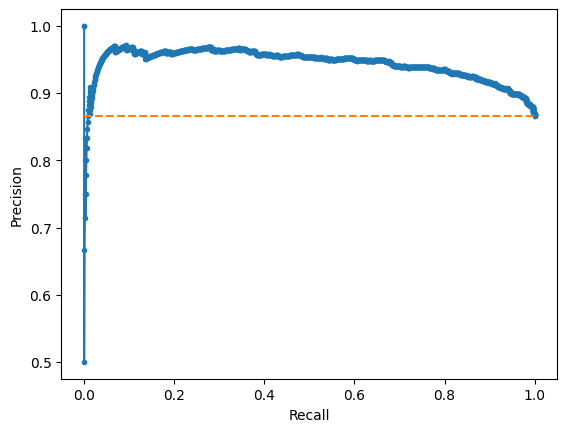

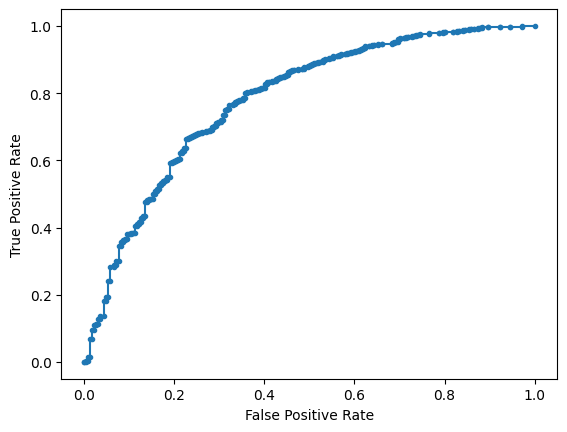

Accuracy: 82.06% Precision: 92.43% Recall: 86.35%
F1: 89.29% MCC: 0.3523
AUPRC: 94.39% AUROC: 77.90%
 accuracy [82.06060606060606]
 precision [92.43445692883896]
 recall [86.35409377186843]
 F1 [89.29088277858176]
 MCC [0.35229471203957263]
 AUPRC [94.38754667305463]
 AUROC [77.89518348115475]
2023-04-02 00:00:29.196624

Training # 2 2
2023-04-02 00:00:29.198338
2023-04-02 00:00:29.198421
Discriminator ZERO 0
Train 1:0 5724:899 86.43%
Computed class weights: {0: 3.6835372636262513, 1: 0.578529000698812}
Valid 1:0 1415:205 87.35%
FIT
2023-04-02 00:00:29.350488


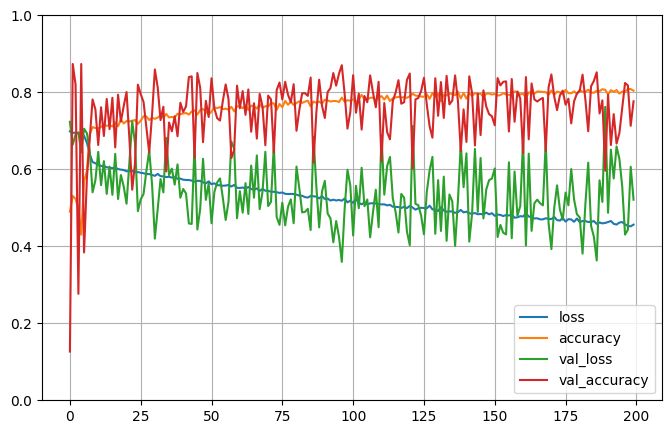


2023-04-02 00:03:37.429551

Testing # 2 2
2023-04-02 00:03:37.430717
2023-04-02 00:03:37.430788
PREDICT
2023-04-02 00:03:37.454589
Test 1:0 1415:205 87.35%
Predict 1:0 1201:419 74.14%
Test sizes (1620, 1025) (1620,)
Range of scores: 0.0021186613 to 0.98976076
Score threshold 0.5
Confusion matrix
 [[ 131   74]
 [ 288 1127]]
Normalized matrix
 [[0.0808642  0.04567901]
 [0.17777778 0.69567901]]


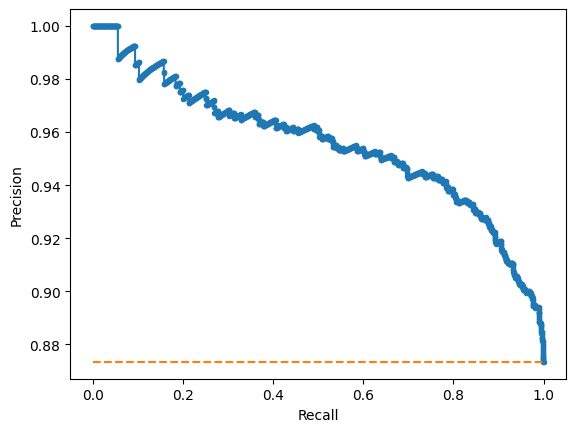

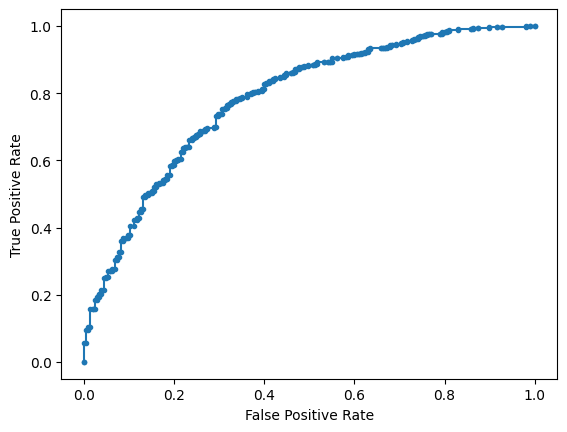

Accuracy: 77.65% Precision: 93.84% Recall: 79.65%
F1: 86.16% MCC: 0.3306
AUPRC: 95.55% AUROC: 78.26%
 accuracy [77.65432098765433]
 precision [93.83846794338052]
 recall [79.64664310954063]
 F1 [86.16207951070336]
 MCC [0.33064018956583124]
 AUPRC [95.5481991249372]
 AUROC [78.2628630526588]
2023-04-02 00:03:38.596620

Training # 2 3
2023-04-02 00:03:38.599721
2023-04-02 00:03:38.599836
Discriminator ZERO 0
Train 1:0 5720:901 86.39%
Computed class weights: {0: 3.674250832408435, 1: 0.5787587412587413}
Valid 1:0 1419:203 87.48%
FIT
2023-04-02 00:03:38.764117


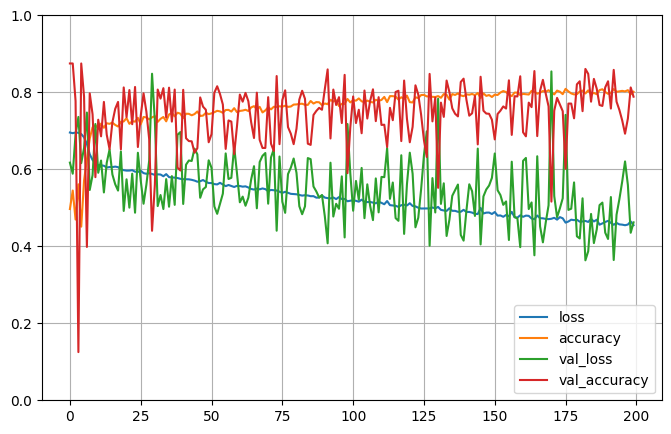


2023-04-02 00:07:03.175162

Testing # 2 3
2023-04-02 00:07:03.177194
2023-04-02 00:07:03.177782
PREDICT
2023-04-02 00:07:03.194739
Test 1:0 1419:203 87.48%
Predict 1:0 1256:366 77.44%
Test sizes (1622, 1025) (1622,)
Range of scores: 0.0030506938 to 0.9935803
Score threshold 0.5
Confusion matrix
 [[ 113   90]
 [ 253 1166]]
Normalized matrix
 [[0.06966708 0.05548705]
 [0.15598027 0.7188656 ]]


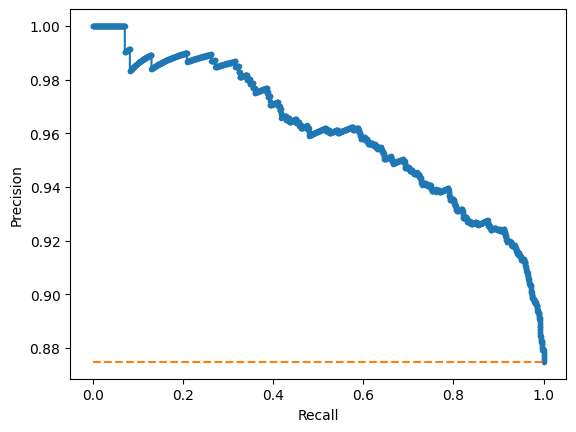

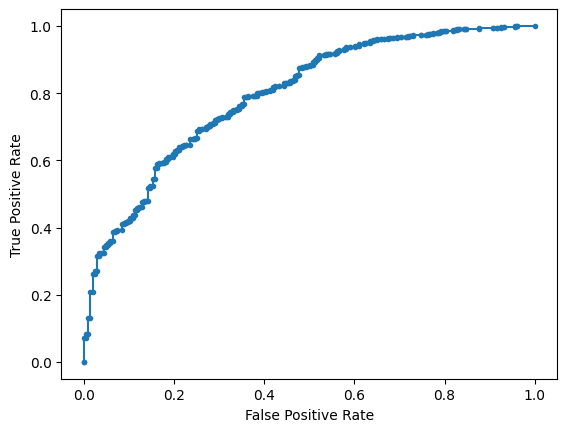

Accuracy: 78.85% Precision: 92.83% Recall: 82.17%
F1: 87.18% MCC: 0.2995
AUPRC: 96.06% AUROC: 79.50%
 accuracy [78.85326757090012]
 precision [92.83439490445859]
 recall [82.17054263565892]
 F1 [87.17757009345793]
 MCC [0.29950501861936296]
 AUPRC [96.06312956738346]
 AUROC [79.49572480446578]
2023-04-02 00:07:04.302360

Training # 2 4
2023-04-02 00:07:04.304000
2023-04-02 00:07:04.304361
Discriminator ZERO 0
Train 1:0 5672:867 86.74%
Computed class weights: {0: 3.771049596309112, 1: 0.5764280677009873}
Valid 1:0 1467:237 86.09%
FIT
2023-04-02 00:07:04.435295


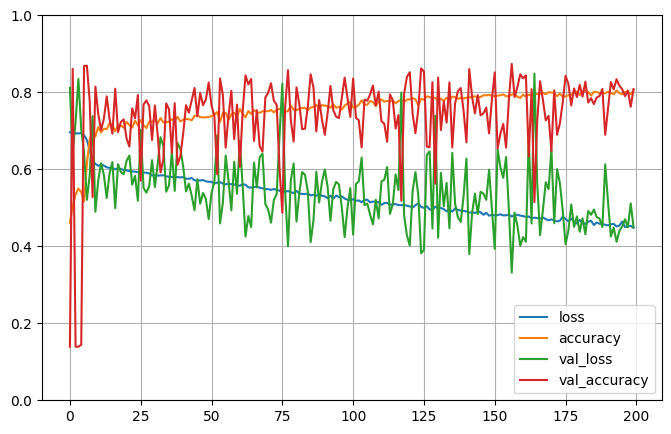


2023-04-02 00:10:28.044750

Testing # 2 4
2023-04-02 00:10:28.046560
2023-04-02 00:10:28.046968
PREDICT
2023-04-02 00:10:28.078108
Test 1:0 1467:237 86.09%
Predict 1:0 1324:380 77.70%
Test sizes (1704, 1025) (1704,)
Range of scores: 0.0018822344 to 0.9971024
Score threshold 0.5
Confusion matrix
 [[ 145   92]
 [ 235 1232]]
Normalized matrix
 [[0.0850939  0.05399061]
 [0.1379108  0.72300469]]


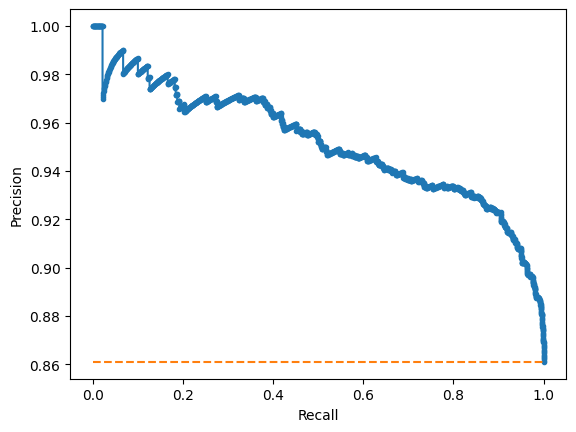

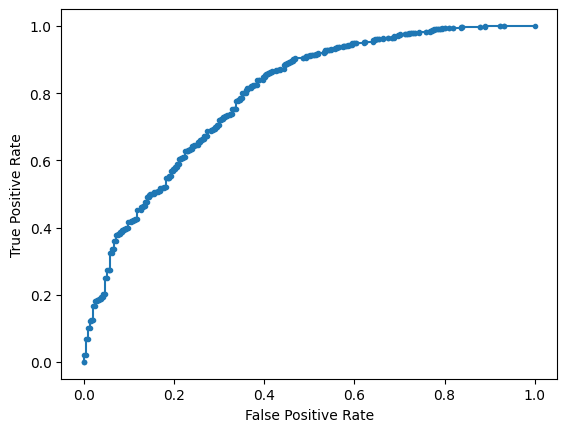

Accuracy: 80.81% Precision: 93.05% Recall: 83.98%
F1: 88.28% MCC: 0.3754
AUPRC: 95.15% AUROC: 79.27%
 accuracy [80.80985915492957]
 precision [93.05135951661632]
 recall [83.98091342876619]
 F1 [88.28376925833035]
 MCC [0.3754308461336926]
 AUPRC [95.14612718576076]
 AUROC [79.26564445940076]
2023-04-02 00:10:29.336328

Training # 2 5
2023-04-02 00:10:29.336909
2023-04-02 00:10:29.337004
Discriminator ZERO 0
Train 1:0 5730:866 86.87%
Computed class weights: {0: 3.808314087759815, 1: 0.5755671902268761}
Valid 1:0 1409:238 85.55%
FIT
2023-04-02 00:10:29.515762


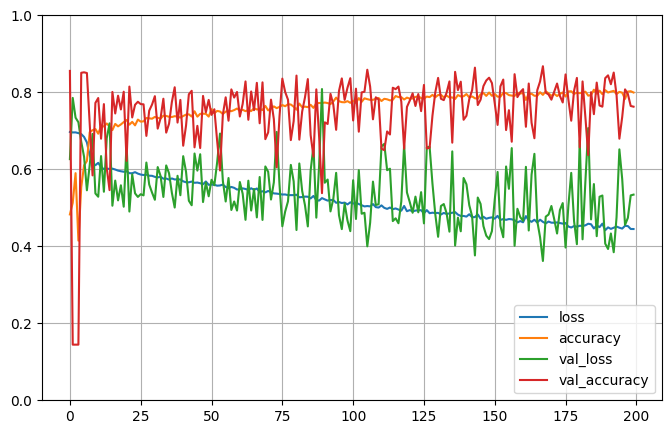


2023-04-02 00:13:25.219878

Testing # 2 5
2023-04-02 00:13:25.220014
2023-04-02 00:13:25.220066
PREDICT
2023-04-02 00:13:25.239894
Test 1:0 1409:238 85.55%
Predict 1:0 1162:485 70.55%
Test sizes (1647, 1025) (1647,)
Range of scores: 0.0013503336 to 0.9974467
Score threshold 0.5
Confusion matrix
 [[ 166   72]
 [ 319 1090]]
Normalized matrix
 [[0.10078931 0.04371585]
 [0.19368549 0.66180935]]


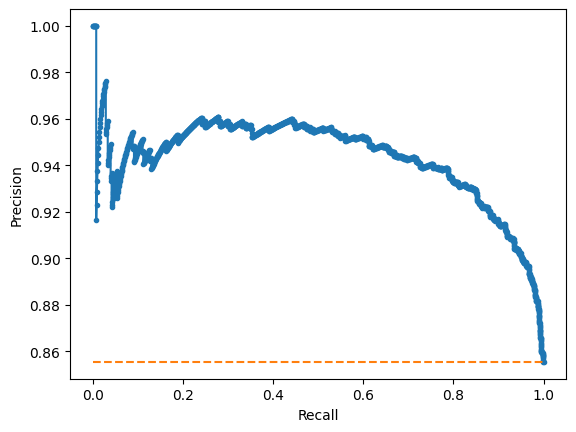

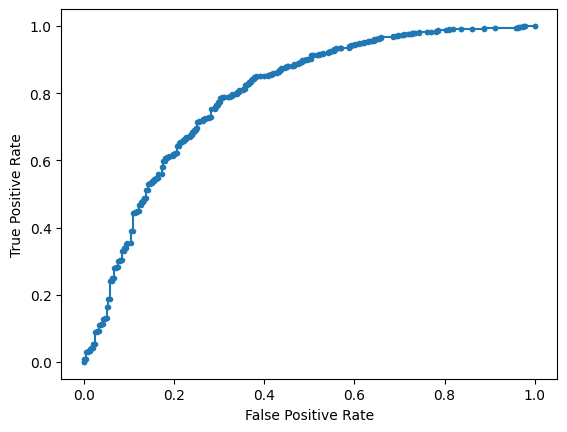

Accuracy: 76.26% Precision: 93.80% Recall: 77.36%
F1: 84.79% MCC: 0.3634
AUPRC: 94.30% AUROC: 79.38%
 accuracy [76.25986642380084]
 precision [93.80378657487091]
 recall [77.35982966643009]
 F1 [84.79190976273824]
 MCC [0.3633809936504721]
 AUPRC [94.30390999194556]
 AUROC [79.37627854548491]
2023-04-02 00:13:26.011397


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 77.25% std 5.30
 precision mean 93.45% std 0.98
 recall mean 79.36% std 7.46
 F1 mean 85.62% std 4.09
 MCC mean 0.34% std 0.03
 AUPRC mean 95.08% std 0.59
 AUROC mean 78.95% std 0.97
 accuracy [[68.11505507955935], [80.75539568345323], [84.49848024316108], [70.3125], [73.16176470588235], [82.06060606060606], [77.65432098765433], [78.85326757090012], [80.80985915492957], [76.25986642380084]]
 precision [[94.53280318091451], [93.59567901234568], [91.80327868852459], [95.12428298279158], [93.51935193519351], [92.43445692883896], [93.83846794338052], [92.83439490445859], [93.05135951661632], [93.80378657487091]]
 recall [[67.1136203246295], [83.59751895244659], [90.19607843137256], [69.19332406119611], [73.95017793594306], [86.35409377186843], [79.64664310954063], [82.17054263565892], [83.98091342876619], [77.35982966643009]]
 F1 [[78.49773008666942], [88.31452493629415], [90.9925821264571], [80.11272141706924], [82.59141494435613], [89.29088277858176], [86.16207951070336], 